# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

In [2]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE


plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [3]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [4]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [5]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (400, 32, 32, 3)


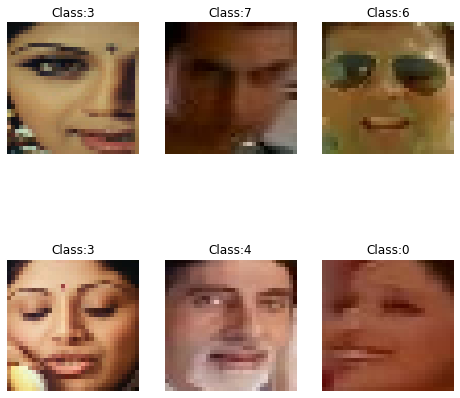

In [6]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [7]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [8]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [9]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [10]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [11]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [12]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [13]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________

Your answers here (double click to edit)
We project our data, which contains a dataset of faces onto the eigenvectors of the covariance matrix. The features we get from this projection along the eigenvectors are called eigenfaces. They are the eigenvectors for faces, hence the name.

1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.
From the eigen specrum, we can find this out. If we consider IMFDB, CFW and Yale, we get 66, 207 and 34 eigenvalues respectively for reconstruction. Threshold taken = 0.9. Code written below

In [14]:
# Compute your features 
# eg.
X_3D_kernel_lda = get_kernel_lda(X,y,3)
X_3D_pca = get_pca(X,100)
X_3D_kernel_pca = get_kernel_pca(X,100)
X_3D_lda = get_lda(X,y, 3)


/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


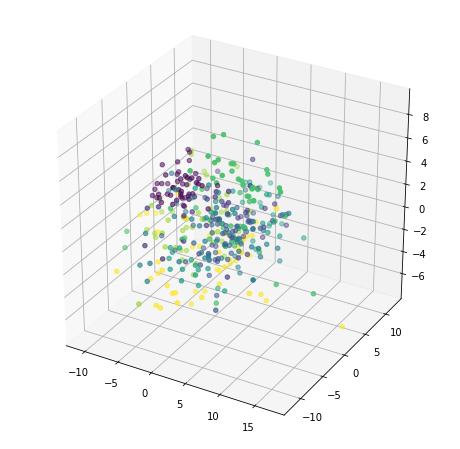

In [15]:
# Create a scatter plot  
# eg.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D_pca[:,0],X_3D_pca[:,1],X_3D_pca[:,2],c=y)

/home/ajay/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


66
Dataset shape: (672, 32, 32, 3)
207
Dataset shape: (165, 32, 32, 3)
34


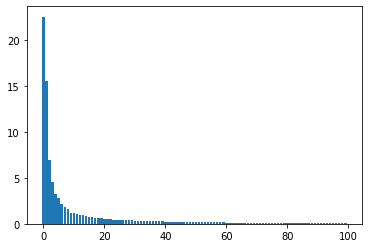

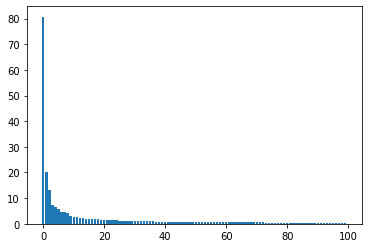

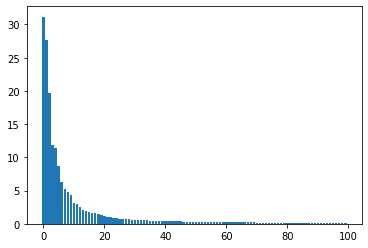

In [16]:
# Plot the eigen value spectrum, code commented out for LDA, kernel LDA,  
# for kernel lda
# plt.figure() 
# eig, vector = linalg.eig(np.cov(np.array(X_3D_kernel_lda).T))
# print(eig.shape)
# plt.bar(np.arange(7),eig)

# for pca
plt.figure()
thresh = 0.9
# eig, vector = linalg.eig(np.cov(np.array(X_3D_pca).T))
# print(eig.shape)

eigval,_ = linalg.eig(np.cov(X.T))
plt.bar(np.arange(100),eigval[:100])
eigval = eigval/np.sum(eigval)
num_eigval = np.sum(np.cumsum(eigval) <= thresh)
print (num_eigval)
#for kernel pca
X,_ = load_data('./dataset/IIIT-CFW')
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
plt.figure()
thresh = 0.9
# eig, vector = linalg.eig(np.cov(np.array(X_3D_pca).T))
# print(eig.shape)

eigval,_ = linalg.eig(np.cov(X.T))
plt.bar(np.arange(100),eigval[:100])
eigval = eigval/np.sum(eigval)
num_eigval = np.sum(np.cumsum(eigval) <= thresh)
print (num_eigval)


X,_ = load_data('./dataset/Yale_face_database/')
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
plt.figure()
thresh = 0.9
# eig, vector = linalg.eig(np.cov(np.array(X_3D_pca).T))
# print(eig.shape)

eigval,_ = linalg.eig(np.cov(X.T))
plt.bar(np.arange(100),eigval[:100])
eigval = eigval/np.sum(eigval)
num_eigval = np.sum(np.cumsum(eigval) <= thresh)
print (num_eigval)
#for LDA
# plt.figure()
# eig, vector = linalg.eig(np.cov(np.array(X_3D_lda).T))
# print(eig.shape)
# plt.bar(np.arange(7),eig)


1(c). Reconstruct  the  image  back for each case


In [17]:
def reconstruct_images(X,k):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    # reconstruction for PCA
    pca = PCA(n_components=k)
    X = pca.fit_transform(X)
    reconstruct_X =  pca.inverse_transform(X)
    
    
#     new_data = data[:, :eig_num]
#     reconstruct_X = projected_data.dot(new_U.T)
    return reconstruct_X    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dataset shape: (400, 32, 32, 3)


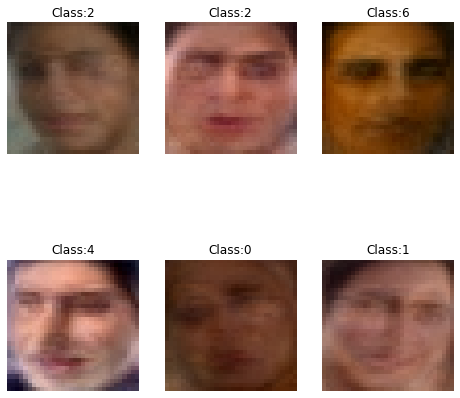

0.06702871872409256


In [18]:
# Display results 

X,y = load_data('./dataset/IMFDB')
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X_reconstructed = reconstruct_images(X,40)

# Display random images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X_reconstructed.reshape(N,H,W,C)[ind,...],y[ind],row=2,col=3)
# Show the reconstruction error
print(np.sqrt(np.mean((X - X_reconstructed)**2)))

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers
Shilpa shetty was the hardest to reconstruct in the IMDB dataset. The reconstruction error was computed using MSE, and finding the class using maximum error, which was defined in function maximum(). Overall, when tested on the cartoon dataset, there were larger errors. This is probably due to large variance of the dataset, which is seen later on in the assignment when we look at the t-SNE observations.

In [19]:
# code goes here
def maximum(arr):
    arr = list(arr)
    return arr.index(max(arr))
def max_reconstruction(X,X_reconstructed):
    errmat = np.zeros(8)
    print (X.shape)
    for i in range(8):
        errmat[i] = np.sqrt(np.mean((X[y==i,:] - X_reconstructed[y==i,:])**2))
    x = []
    x = list(imfdb_dict.keys())
    max_reconstruct = x[maximum(errmat)]
    return max_reconstruct
print("Max error:",max_reconstruction(X,X_reconstructed))

    

(400, 3072)
Max error: ShilpaShetty


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 
Accuracy printed below, approximately 86%.

2(b)Which method works well? Do a comparitivestudy. 
The models with the best confusion matrices are printed for each dataset (IMFDB, Yale, CFW). Logistic regression with Resnet features seems to work very well. Table printed below.

You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [20]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.svm import SVC,LinearSVR
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as confMat
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

class Classifier():
    def __init__(self):
#         super(self.__class__, self).__init__()
        self.max_iter = 2000
#         self.classification = SVC(kernel='linear', C=3, max_iter=self.max_iter, gamma = 0.1)
#         self.classification = None
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        
        prediction = self.classification.predict(X)
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        
        confMat = confusion_matrix(y,pred)

        return confMat, confMat
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.classification.fit(X_train,y_train)
    def training_fn(self,class_type,x,y): 
        types = ['lr','svm','mlp','dt']
        if (class_type ==types[0]):
            self.classification = LogisticRegression(multi_class = 'auto',max_iter=self.max_iter)
            self.classification.fit(x,y)
        elif (class_type == types[1]):
            self.classification = SVC(kernel='linear', C=1000,  gamma = 'auto', max_iter=self.max_iter)
            self.classification.fit(x, y)
        elif (class_type == types[2]):
            self.classification = MLPClassifier(hidden_layer_sizes=(100,100),max_iter=self.max_iter)
            self.classification.fit(x, y)
        elif (class_type == types[3]):
            self.classification = tree.DecisionTreeClassifier()
            self.classification.fit(x,y)
        
            
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        

        # Create a confusion matrix
        classify_res = self.classify(X_validate)
        confmat,frame = self.confusion_matrix(classify_res,y_validate)
        # Calculate Validation accuracy 
        acc = accuracy_score(y_validate,classify_res,normalize = True)
        # Calculate precision and recall 
        precision = precision_score(y_validate,classify_res,average = 'macro')
        recall = recall_score(y_validate,classify_res,average = 'macro')
        # Calculate F1-score
        f1 = f1_score(y_validate,classify_res,average='macro') 
        
#         print (acc)
#         print (recall)
#         print (f1)
    
        return acc,precision,f1,frame

Dataset shape: (400, 32, 32, 3)
Accuracy 86.25


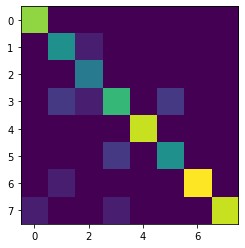

In [21]:
# Create a train and validation split to train your classifier
#for features
list = ['./dataset/IMFDB/','./dataset/IIIT-CFW/','./dataset/Yale_face_database/']
x,y = load_data(list[0])
n = x.shape[0]
h = x.shape[1]
w = x.shape[2]
c = 1 if opt['is_grayscale'] else x.shape[3]
x = x.reshape((n,h*w*c))
train_1, test_1,train_2,test_2 = train_test_split(x, y, test_size=0.2, random_state=42)
clf = Classifier()
clf.training_fn('svm',train_1,train_2)
acc,prec,f1, frame = clf.validate(test_1, test_2)
print ('Accuracy',acc*100)
plt.imshow(frame)
#for resnet features in a later question
# imfdb_x_train_res,imfdb_x_test_res,imfdb_y_train_res,imfdb_y_test_res = train_test_split(load_data(features_1[4]),load_data(list[0])[1],test_size = 0.2,random_state = 42)
# iiit_x_train_res,iiit_x_test_res,iiit_y_train_res,iiit_y_test_res = train_test_split(load_data(list[1])[0],load_data(list[1])[1],test_size = 0.2,random_state = 42)
# yale_x_train_res,yale_x_test_res,yale_y_train_res,yale_y_test_res = train_test_split(load_data(list[2])[0],load_data(list[2])[1],test_size = 0.2,random_state = 42)


Dataset shape: (400, 32, 32, 3)


/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion matrix of best classifier of IMFDB


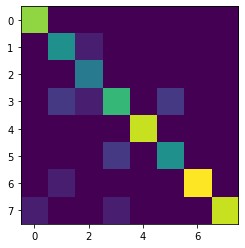

/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Method,RedDim,Error,Accuracy,F1 Score
1,Resnet+lr,2048,5.0,95.0,0.945500
2,Resnet+svm,2048,5.0,95.0,0.951161
3,Resnet+mlp,2048,5.0,95.0,0.945500
4,pca+svm,100,20.0,80.0,0.802413
5,pca+mlp,100,20.0,80.0,0.805013


Dataset shape: (672, 32, 32, 3)


/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion matrix of best classifier of CFW


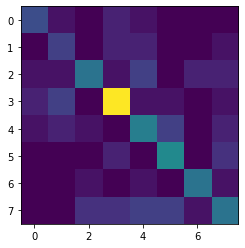

/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


,Method,RedDim,Error,Accuracy,F1 Score
1,Resnet+lr,2048,2.222222,97.777778,0.979284
2,Resnet+svm,2048,2.962963,97.037037,0.969331
3,Resnet+mlp,2048,1.481481,98.518519,0.984608
4,pca+svm,100,52.592593,47.407407,0.475997
5,pca+mlp,100,46.666667,53.333333,0.530815


Dataset shape: (165, 32, 32, 3)


/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix of best classifier of Yale


/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


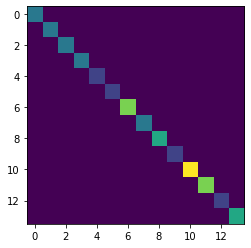

/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metr

,Method,RedDim,Error,Accuracy,F1 Score
1,Resnet+lr,2048,0.000000,100.000000,1.000000
2,Resnet+svm,2048,3.030303,96.969697,0.952381
3,Resnet+mlp,2048,6.060606,93.939394,0.927891
4,pca+svm,100,9.090909,90.909091,0.868367
5,pca+mlp,100,15.151515,84.848485,0.789116


In [22]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.svm import SVC,LinearSVR
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as confMat
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd

def maximum(arr):
    arr = list(arr)
    return arr.index(max(arr))
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score
yale = []
frame_yale = []
frame = []
frames_data = []
max_yale = []
maximum1 = []
feature=get_resnet_features('./dataset/IMFDB')
types = ['lr','svm','mlp','dt']
types1 = ['lr','svm','mlp']
types2 = ['svm','mlp']
x,y = load_data('./dataset/IMFDB')
confusion = []
c = 1 if opt['is_grayscale'] else x.shape[3]
n = x.shape[0]
h = x.shape[1]
w = x.shape[2]
x = x.reshape((n,h*w*c))
train_1,test_1,train_2,test_2 = train_test_split(x,y,test_size=0.2, random_state=42)
# clf = Classifier()
for i in types:
    clf = Classifier()
    clf.training_fn(i,train_1,train_2)
    acc,precision,f1,frame = clf.validate(test_1,test_2)
    yale.append(acc)
    frames_data.append(frame) 
    confusion.append(frame)
max_yale.append(np.argmax(yale))
maximum1.append(confusion[max_yale[0]])
print ("Confusion matrix of best classifier of IMFDB")
plt.imshow(confusion[max_yale[0]])
plt.show()
train_1,test_1,train_2,test_2=train_test_split(feature,y,test_size=0.2,random_state=42)
for i in types1:
    clf = Classifier()
    clf.training_fn(i,train_1,train_2)
    acc,precision,f1,frame = clf.validate(test_1,test_2)
    num = feature.shape[1]
    acc = acc*100
    err = 100-acc
    frame_yale.append(['Resnet+{}'.format(i),num,err,acc,f1])

feature1=get_pca(x,100)
train_1,test_1,train_2,test_2=train_test_split(feature1,y,test_size=0.2,random_state=42)

for i in types2:
    
    clf.training_fn(i,train_1,train_2)
    acc,precision,f1,frame = clf.validate(test_1,test_2)
    num = feature1.shape[1]
    acc = acc*100
    err = 100-acc
    frame_yale.append(['pca+{}'.format(i),num,err,acc,f1])
    
df1 = pd.DataFrame(frame_yale,columns=['Method','RedDim','Error','Accuracy','F1 Score'],index = ['1','2','3','4','5'])
display(df1)
    
yale = []
frame_yale = []
frame = []
frames_data = []
max_yale = []
maximum1 = []
confusion = []
feature=get_resnet_features('./dataset/IIIT-CFW/')

x,y = load_data('./dataset/IIIT-CFW/')

c = 1 if opt['is_grayscale'] else x.shape[3]
n = x.shape[0]
h = x.shape[1]
w = x.shape[2]
x = x.reshape((n,h*w*c))
train_1,test_1,train_2,test_2 = train_test_split(x,y,test_size=0.2, random_state=42)
# clf = Classifier()
for i in types:
    clf = Classifier()
    clf.training_fn(i,train_1,train_2)
    acc,precision,f1,frame = clf.validate(test_1,test_2)
    yale.append(acc)
    frames_data.append(frame) 
    confusion.append(frame)
    
max_yale.append(np.argmax(yale))
maximum1.append(confusion[max_yale[0]])
print ("Confusion matrix of best classifier of CFW")
plt.imshow(confusion[max_yale[0]])
plt.show()
train_1,test_1,train_2,test_2=train_test_split(feature,y,test_size=0.2,random_state=42)
for i in types1:
    clf = Classifier()
    clf.training_fn(i,train_1,train_2)
    acc,precision,f1,frame = clf.validate(test_1,test_2)
    num = feature.shape[1]
    acc = acc*100
    err = 100-acc
    frame_yale.append(['Resnet+{}'.format(i),num,err,acc,f1])

feature1=get_pca(x,100)
train_1,test_1,train_2,test_2=train_test_split(feature1,y,test_size=0.2,random_state=42)

for i in types2:
    
    clf.training_fn(i,train_1,train_2)
    acc,precision,f1,frame = clf.validate(test_1,test_2)
    num = feature1.shape[1]
    acc = acc*100
    err = 100-acc
    frame_yale.append(['pca+{}'.format(i),num,err,acc,f1])

df1 = pd.DataFrame(frame_yale,columns=['Method','RedDim','Error','Accuracy','F1 Score'],index = ['1','2','3','4','5'])
display(df1) 

yale = []
frame_yale = []
frame = []
frames_data = []
max_yale = []
feature=get_resnet_features('./dataset/Yale_face_database/')

x,y = load_data('./dataset/Yale_face_database/')
confusion = []
c = 1 if opt['is_grayscale'] else x.shape[3]
n = x.shape[0]
h = x.shape[1]
w = x.shape[2]
x = x.reshape((n,h*w*c))
train_1,test_1,train_2,test_2 = train_test_split(x,y,test_size=0.2, random_state=42)
# clf = Classifier()
for i in types:
    clf = Classifier()
    clf.training_fn(i,train_1,train_2)
    acc,precision,f1,frame = clf.validate(test_1,test_2)
    yale.append(acc)
    frames_data.append(frame)
    confusion.append(frame)
max_yale.append(np.argmax(yale))
maximum1.append(confusion[max_yale[0]])
print ("Confusion matrix of best classifier of Yale")
plt.imshow(confusion[max_yale[0]])
plt.show()

train_1,test_1,train_2,test_2=train_test_split(feature,y,test_size=0.2,random_state=42)
for i in types1:
    clf = Classifier()
    clf.training_fn(i,train_1,train_2)
    acc,precision,f1,frame = clf.validate(test_1,test_2)
    num = feature.shape[1]
    acc = acc*100
    err = 100-acc
    frame_yale.append(['Resnet+{}'.format(i),num,err,acc,f1])

feature1=get_pca(x,100)
train_1,test_1,train_2,test_2=train_test_split(feature1,y,test_size=0.2,random_state=42)

for i in types2:
    
    clf.training_fn(i,train_1,train_2)
    acc,precision,f1,frame = clf.validate(test_1,test_2)
    num = feature1.shape[1]
    acc = acc*100
    err = 100-acc
    frame_yale.append(['pca+{}'.format(i),num,err,acc,f1])

df1 = pd.DataFrame(frame_yale,columns=['Method','RedDim','Error','Accuracy','F1 Score'],index = ['1','2','3','4','5'])
display(df1) 
        

In [23]:
# For each dataset print the confusion matrix for the best model
#Done in previous output, please see the confusion matrices


3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.
Ans: T-SNE works better than PCA since it is a better form of clustering. There are still some outliers, but it still is more effective than PCA. Plots printed below. Another point to be noted is that when LDA is used first, we get better results, which has been plotted as well.

Dataset shape: (400, 32, 32, 3)


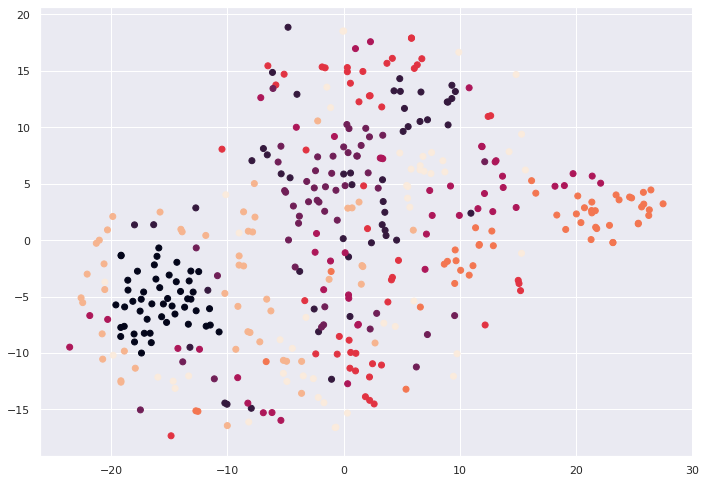

Dataset shape: (672, 32, 32, 3)


<Figure size 842.4x595.44 with 0 Axes>

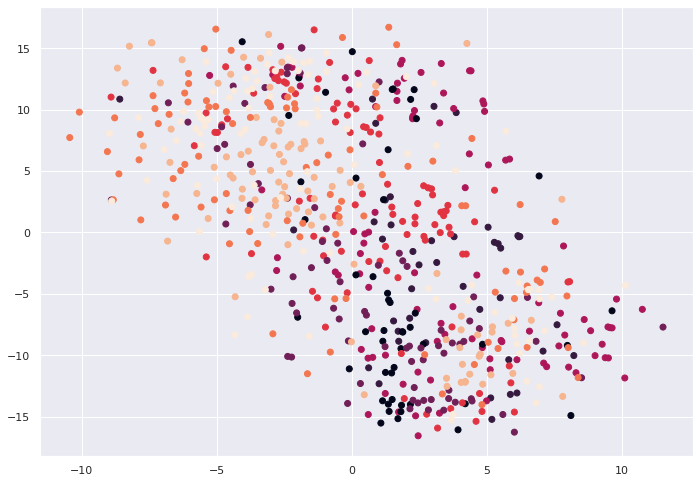

Dataset shape: (165, 32, 32, 3)


<Figure size 842.4x595.44 with 0 Axes>

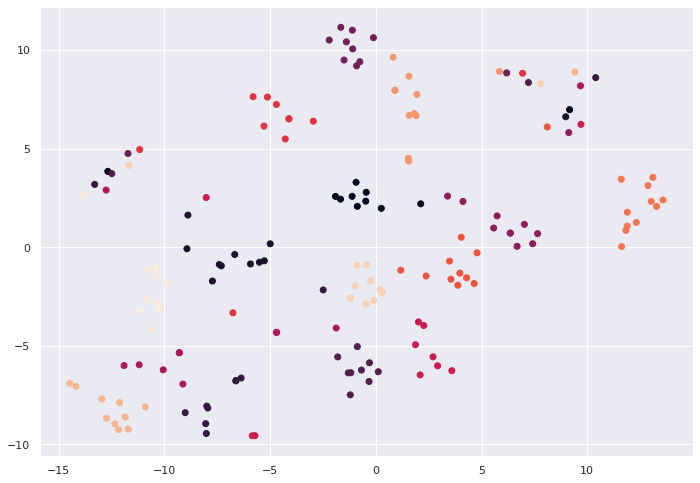

<Figure size 842.4x595.44 with 0 Axes>

In [24]:
# Compute TSNE for different features and create a scatter plot
from sklearn.manifold import TSNE
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 7)
# X =  # feature 
for i in ['./dataset/IMFDB/','./dataset/IIIT-CFW/','./dataset/Yale_face_database/']:
    X,y = load_data(i)
    k = 2
    col = 1 
    if opt['is_grayscale'] == False:
        col = X.shape[3]
    
    X = X.reshape((X.shape[0],X.shape[1]*X.shape[2]*col))
    if (k==2):
        X_TSNE_2 = TSNE(n_components=k).fit_transform(X)
        plt.figure()
        plt.scatter(X_TSNE_2[:,0],X_TSNE_2[:,1],c=y)
    
        plt.show()
    fig = plt.figure()
    if (k == 3): # Number of components in TSNE
        X_TSNE_3 = TSNE(n_components=k).fit_transform(X)
        scat = fig.add_subplot(111, projection='3d')
        scat.scatter(X_TSNE_3[:,0],X_TSNE_3[:,1],X_TSNE_3[:,2],c=y)
        plt.show()
    



With LDA
Dataset shape: (400, 32, 32, 3)


/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


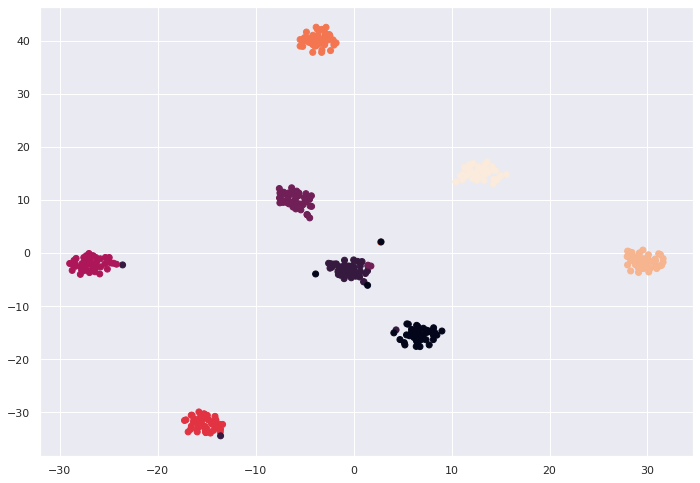

Dataset shape: (672, 32, 32, 3)


/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


<Figure size 842.4x595.44 with 0 Axes>

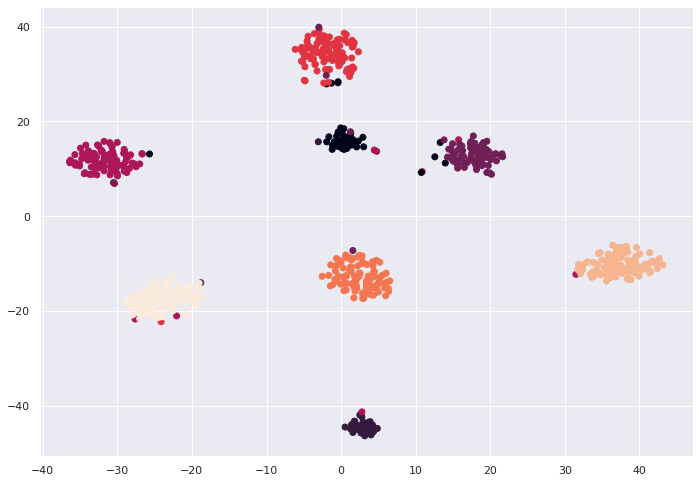

Dataset shape: (165, 32, 32, 3)


/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


<Figure size 842.4x595.44 with 0 Axes>

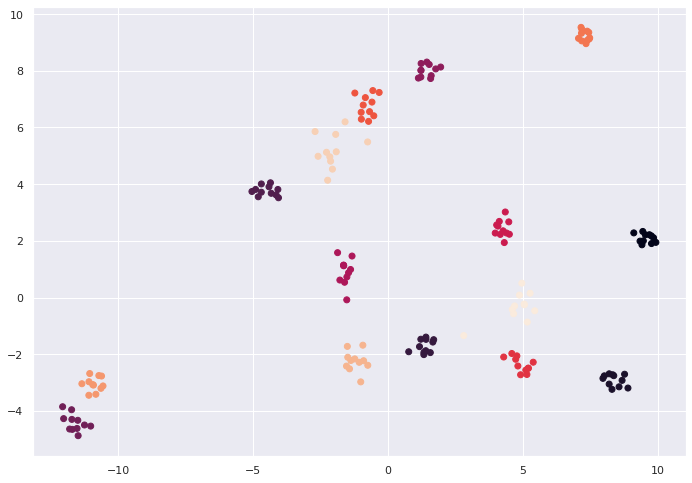

<Figure size 842.4x595.44 with 0 Axes>

In [25]:
#using features extracted by LDA to get better results
print ("With LDA")
from sklearn.manifold import TSNE
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 7)
# X =  # feature 
for i in ['./dataset/IMFDB/','./dataset/IIIT-CFW/','./dataset/Yale_face_database/']:
    X,y = load_data(i)
    k = 2
    col = 1 
    if opt['is_grayscale'] == False:
        col = X.shape[3]
    
    X = X.reshape((X.shape[0],X.shape[1]*X.shape[2]*col))
    X = get_lda(X,y,6)
    if (k==2):
        X_TSNE_2 = TSNE(n_components=k).fit_transform(X)
        plt.figure()
        plt.scatter(X_TSNE_2[:,0],X_TSNE_2[:,1],c=y)
    
        plt.show()
    fig = plt.figure()
    if (k == 3): # Number of components in TSNE
        X_TSNE_3 = TSNE(n_components=k).fit_transform(X)
        scat = fig.add_subplot(111, projection='3d')
        scat.scatter(X_TSNE_3[:,0],X_TSNE_3[:,1],X_TSNE_3[:,2],c=y)
        plt.show()
    

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

Answer: We use the distance metric of the projections in order to do this. We can define the classifier by finding out the class depending on how far away a point/data is away from each class. The classifier for this problem is coded, along with the printing of accuracies.

In [26]:
from sklearn.neighbors import KNeighborsClassifier
class FaceVerification():
    def __init__(self,k=5):
#         super.__init__()
        self.neigh = k
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        res = self.clf.predict(X)
        verification_results = (class_id == res)
        return verification_results
        
    def train(self,x,y,k = 5):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        class_type = k
        types = [3,5,7,11]
        if (class_type == types[0]):
            self.clf = KNeighborsClassifier(n_neighbors = types[0])
            self.clf.fit(x,y)
        elif (class_type == types[1]):
            self.clf = KNeighborsClassifier(n_neighbors = types[1])
            self.clf.fit(x, y)
        elif (class_type == types[2]):
            self.clf = KNeighborsClassifier(n_neighbors = types[2])
            self.clf.fit(x, y)
        elif (class_type == types[3]):
            self.clf = KNeighborsClassifier(n_neighbors = types[3])
            self.clf.fit(x,y)
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        accuracy = (np.mean(self.verify(X_validate,y_validate)))
        error = 1 - accuracy
        prec = precision_score(y_validate,self.clf.predict(X_validate),average = 'macro')
        return error,accuracy,prec

In [27]:
# Create a train and validation split and show your results 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
clf = FaceVerification()
clf.train(X_train, y_train)
clf.validate(X_test, y_test)

/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.2727272727272727, 0.7272727272727273, 0.719047619047619)

In [28]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision
yale = []
frame_yale = []
frame = []
frames_data = []
max_yale = []
feature=get_resnet_features("./dataset/Yale_face_database")

x,y = load_data("./dataset/Yale_face_database")

c = 1 if opt['is_grayscale'] else x.shape[3]
n = x.shape[0]
h = x.shape[1]
w = x.shape[2]
x = x.reshape((n,h*w*c))
types = [3,5,7,11]
types1 = [3,5,7]
types2 = [5,7]
train_1,test_1,train_2,test_2 = train_test_split(x,y,test_size=0.2, random_state=42)
# clf = Classifier()
for i in types:
    clf = FaceVerification()
    clf.train(train_1,train_2,k=i)
    _,acc,precision = clf.validate(test_1,test_2)
    yale.append(acc)
max_yale.append(np.argmax(yale))
train_1,test_1,train_2,test_2=train_test_split(feature,y,test_size=0.2,random_state=42)
for i in types1:
    clf = FaceVerification()
    clf.train(train_1,train_2,k=i)
    _,acc,precision = clf.validate(test_1,test_2)
    num = feature.shape[1]
    acc = acc*100
    err = 100-acc
    frame_yale.append(['Resnet+{}'.format(i),num,err,acc,precision])

feature1=get_pca(x,100)
train_1,test_1,train_2,test_2=train_test_split(feature1,y,test_size=0.2,random_state=42)

for i in types2:
    
    clf.train(train_1,train_2,k=i)
    _,acc,precision = clf.validate(test_1,test_2)
    num = feature1.shape[1]
    acc = acc*100
    err = 100-acc
    frame_yale.append(['pca+{}'.format(i),num,err,acc,precision])

df1 = pd.DataFrame(frame_yale,columns=['Method','RedDim','Error','Accuracy','precision'],index = ['1','2','3','4','5'])
display(df1)
    
yale = []
frame_yale = []
frame = []
frames_data = []
max_yale = []
feature=get_resnet_features('./dataset/IIIT-CFW/')

x,y = load_data('./dataset/IIIT-CFW/')

c = 1 if opt['is_grayscale'] else x.shape[3]
n = x.shape[0]
h = x.shape[1]
w = x.shape[2]
x = x.reshape((n,h*w*c))
types = [3,5,7,11]
types1 = [3,5,7]
types2 = [5,7]
train_1,test_1,train_2,test_2 = train_test_split(x,y,test_size=0.2, random_state=42)
# clf = Classifier()
for i in types:
    clf = FaceVerification()
    clf.train(train_1,train_2,k=i)
    _,acc,precision = clf.validate(test_1,test_2)
    yale.append(acc)
max_yale.append(np.argmax(yale))
train_1,test_1,train_2,test_2=train_test_split(feature,y,test_size=0.2,random_state=42)
for i in types1:
    clf = FaceVerification()
    clf.train(train_1,train_2,k=i)
    _,acc,precision = clf.validate(test_1,test_2)
    num = feature.shape[1]
    acc = acc*100
    err = 100-acc
    frame_yale.append(['Resnet+{}'.format(i),num,err,acc,precision])

feature1=get_pca(x,100)
train_1,test_1,train_2,test_2=train_test_split(feature1,y,test_size=0.2,random_state=42)

for i in types2:
    
    clf.train(train_1,train_2,k=i)
    _,acc,precision = clf.validate(test_1,test_2)
    num = feature1.shape[1]
    acc = acc*100
    err = 100-acc
    frame_yale.append(['pca+{}'.format(i),num,err,acc,precision])

df1 = pd.DataFrame(frame_yale,columns=['Method','RedDim','Error','Accuracy','precision'],index = ['1','2','3','4','5'])
display(df1)

yale = []
frame_yale = []
frame = []
frames_data = []
max_yale = []
feature=get_resnet_features('./dataset/Yale_face_database/')

x,y = load_data('./dataset/Yale_face_database/')

c = 1 if opt['is_grayscale'] else x.shape[3]
n = x.shape[0]
h = x.shape[1]
w = x.shape[2]
x = x.reshape((n,h*w*c))
types = [3,5,7,11]
types1 = [3,5,7]
types2 = [5,7]
train_1,test_1,train_2,test_2 = train_test_split(x,y,test_size=0.2, random_state=42)
# clf = Classifier()
for i in types:
    clf = FaceVerification()
    clf.train(train_1,train_2,k=i)
    _,acc,precision = clf.validate(test_1,test_2)
    yale.append(acc)
max_yale.append(np.argmax(yale))
train_1,test_1,train_2,test_2=train_test_split(feature,y,test_size=0.2,random_state=42)
for i in types1:
    clf = FaceVerification()
    clf.train(train_1,train_2,k=i)
    _,acc,precision = clf.validate(test_1,test_2)
    num = feature.shape[1]
    acc = acc*100
    err = 100-acc
    frame_yale.append(['Resnet+{}'.format(i),num,err,acc,precision])

feature1=get_pca(x,100)
train_1,test_1,train_2,test_2=train_test_split(feature1,y,test_size=0.2,random_state=42)

for i in types2:
    
    clf.train(train_1,train_2,k=i)
    _,acc,precision = clf.validate(test_1,test_2)
    num = feature1.shape[1]
    acc = acc*100
    err = 100-acc
    frame_yale.append(['pca+{}'.format(i),num,err,acc,precision])

df1 = pd.DataFrame(frame_yale,columns=['Method','RedDim','Error','Accuracy','precision'],index = ['1','2','3','4','5'])
display(df1)

        
# Print the table. (You can use Pandas)

Dataset shape: (165, 32, 32, 3)


/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ajay/anaconda3/lib/pyt

,Method,RedDim,Error,Accuracy,precision
1,Resnet+3,2048,0.000000,100.000000,1.000000
2,Resnet+5,2048,0.000000,100.000000,1.000000
3,Resnet+7,2048,0.000000,100.000000,1.000000
4,pca+5,100,27.272727,72.727273,0.719048
5,pca+7,100,33.333333,66.666667,0.684524


Dataset shape: (672, 32, 32, 3)


/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Method,RedDim,Error,Accuracy,precision
1,Resnet+3,2048,2.222222,97.777778,0.975815
2,Resnet+5,2048,2.962963,97.037037,0.973280
3,Resnet+7,2048,2.962963,97.037037,0.974877
4,pca+5,100,59.259259,40.740741,0.458360
5,pca+7,100,58.518519,41.481481,0.514942


Dataset shape: (165, 32, 32, 3)


/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ajay/anaconda3/lib/pyt

,Method,RedDim,Error,Accuracy,precision
1,Resnet+3,2048,0.000000,100.000000,1.000000
2,Resnet+5,2048,0.000000,100.000000,1.000000
3,Resnet+7,2048,0.000000,100.000000,1.000000
4,pca+5,100,27.272727,72.727273,0.719048
5,pca+7,100,33.333333,66.666667,0.684524


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

Answer: Classification of the politicians and non politicians has been done in this question. First, the data from the CFW dataset has been loaded, and we defined a dictionary for whether a class is a politician or not. Armed with these labels, we can get the features using PCA for the entire data. 40 components were used in this particular problem. We defined an SVM classifier for the purpose of classifying on these reduced dimensions, and at the end we get an accuracy. The results were analysed across 3 different folds for cross validation (result:[93.33333333 98.51851852 97.01492537 99.25373134 94.7761194 ]), and the results were analysed using TSNE, the graphs of which can be seen in the 2d space.

In [34]:
# Load data


def data(dir_path):
    x_list = []
    #fix the combined labels
    
    label_dict = pol  
    
    #from load data given in a previous cell
    for filename in sorted(os.listdir(dir_path)):
        if (".png") in filename:
            im = load_image(os.path.join(dir_path,filename))
            x = filename.split('_')[0]
            x = label_dict[x] 
            x_list.append(x)
        else:
            continue

    
    x_list = np.array(x_list)

#     print("Dataset shape:",image_list.shape)

    return x_list
politician={'pol':1,'nonpol':0}
pol = {
    'ManmohanSingh': 1,
    'VladimirPutin': 1,
    'AishwaryaRai': 0,
    'Amitabhbachan': 0,
    'AamirKhan': 0,
    'DwayneJohnson': 0,
    'BarackObama': 1,
    'NarendraModi': 1,
    }

x = get_resnet_features('./dataset/IIIT-CFW/')
y = data('./dataset/IIIT-CFW/')
print (x.shape)
print (y.shape)

(672, 2048)
(672,)


In [35]:
# Define your features
#pca features
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.2)
X_train = get_pca(X_train,40)
X_test = get_pca(X_test,40)


In [56]:
# Create your classifier


class Classifier():
    def __init__(self):
        self.max_iter = 2000
 
    def classify(self,X):
        prediction = self.classification.predict(X)
        return prediction
        
    def confusion_matrix(self,pred,y):
        confMat = confusion_matrix(y,pred)
        confusion = pd.DataFrame(data = confMat)
        return confMat, confusion
    def train(self,X_train,y_train):
        self.classification.fit(X_train,y_train)
    def training_fn(self,class_type,x,y): 
        types = ['lr','svm','mlp','dt']
        if (class_type ==types[0]):
            self.classification = LogisticRegression(multi_class = 'auto',max_iter=self.max_iter)
            self.classification.fit(x,y)
        elif (class_type == types[1]):
            self.classification = SVC(kernel='rbf', C=100,  gamma = 200, max_iter=self.max_iter)
            self.classification.fit(x, y)
        elif (class_type == types[2]):
            self.classification = MLPClassifier(hidden_layer_sizes=(200,50),max_iter=self.max_iter)
            self.classification.fit(x, y)
        elif (class_type == types[3]):
            self.classification = tree.DecisionTreeClassifier()
            self.classification.fit(x,y)
        
            
    def validate(self,X_validate,y_validate):
        # Create a confusion matrix
        classify_res = self.classify(X_validate)
        confmat,frame = self.confusion_matrix(classify_res,y_validate)
        # Calculate Validation accuracy 
        acc = accuracy_score(y_validate,classify_res,normalize = True)
        # Calculate precision and recall 
        precision = precision_score(y_validate,classify_res,average = 'macro')
        recall = recall_score(y_validate,classify_res,average = 'macro')
        # Calculate F1-score
        f1 = f1_score(y_validate,classify_res,average='macro') 
        
#         
    
        return acc,precision,f1,frame
# Validate your classifier
clf = Classifier()
clf.training_fn('svm',X_train,y_train)
pred = clf.classify(X_test)


Accuracy:
57.77777777777777
KFold accuracy [93.33333333 98.51851852 97.01492537 99.25373134 94.7761194 ]
Black: Politician class White:Non politician class


/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ajay/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


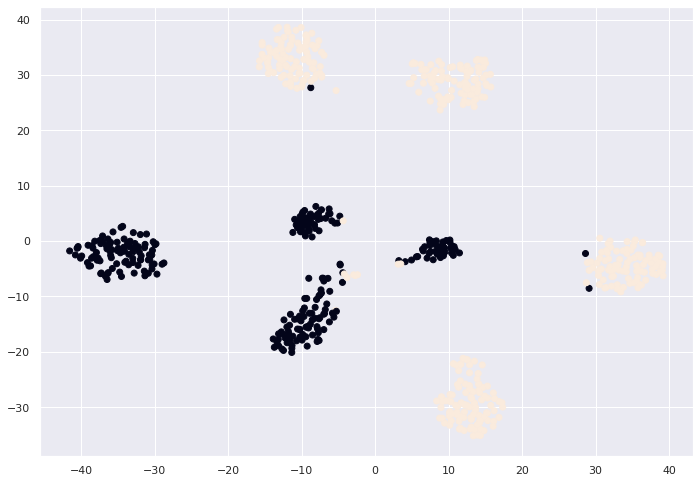

In [57]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.  
from sklearn.model_selection import cross_val_score
print ("Accuracy:")
print(np.mean(pred == y_test)*100)

cross_val = cross_val_score(SVC(kernel='linear', C=1000,  gamma = 'auto', max_iter=1000),x,y,cv=5)
print ("KFold accuracy",cross_val*100)

from sklearn.manifold import TSNE
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 7)
# X =  # feature 

# X,y = load_data('./dataset/IIIT-CFW/')
k = 2
col = 1 
print ('Black: Politician class','White:Non politician class')
x = get_pca(x,40)
if (k==2):
    X_TSNE_2 = TSNE(n_components=k).fit_transform(x)
    plt.figure()
    plt.scatter(X_TSNE_2[:,0],X_TSNE_2[:,1],c=y)
    plt.show()

